# Working around Decision Tree-based models

### Load and Analyze Clean Data

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load your preprocessed data
print("Loading preprocessed data...")
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')

with open('preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"✓ Train: {train_df.shape[0]:,} samples from {train_df['well_id'].nunique()} wells")
print(f"✓ Val: {val_df.shape[0]:,} samples from {val_df['well_id'].nunique()} wells")

# Get your clean feature list
feature_cols = [f for f in metadata['predictor_features'] 
                if f not in ['ppp', 'pressure_ratio', 'overpressure']]
print(f"\nFeatures ({len(feature_cols)}): {', '.join(feature_cols)}")

# Analyze feature distributions and correlations
print("\n" + "="*50)
print("FEATURE ANALYSIS")
print("="*50)

# Check correlations with target
correlations = train_df[feature_cols + ['ppp']].corr()['ppp'].sort_values(ascending=False)
print("\nTop correlations with PPP:")
for feat, corr in correlations[1:6].items():
    print(f"  {feat:20s}: {corr:+.3f}")
print("...")
for feat, corr in correlations[-5:].items():
    print(f"  {feat:20s}: {corr:+.3f}")

# Check feature coverage
print("\nFeature coverage in validation set:")
coverage = val_df[feature_cols].notna().sum() / len(val_df)
for feat, cov in coverage.items():
    status = "✓" if cov > 0.95 else "⚠" if cov > 0.8 else "✗"
    print(f"  {status} {feat:20s}: {cov*100:.1f}%")

# Analyze pressure regimes
print("\n" + "="*50)
print("PRESSURE REGIME ANALYSIS")  
print("="*50)

for name, df in [('Train', train_df), ('Val', val_df)]:
    print(f"\n{name} set:")
    
    # Pressure statistics
    ratio = df['ppp'] / df['hp']
    print(f"  PPP/HP ratio: {ratio.mean():.2f} ± {ratio.std():.2f}")
    print(f"  Overpressure range: {df['overpressure'].min():.0f} to {df['overpressure'].max():.0f} psi")
    
    # Regime distribution
    regimes = pd.cut(ratio, bins=[0, 0.9, 1.1, 3.0], 
                     labels=['Under', 'Normal', 'Over'])
    dist = regimes.value_counts(normalize=True).sort_index()
    print(f"  Regimes: {', '.join([f'{r}={v*100:.1f}%' for r,v in dist.items()])}")

# Check for anomalies
print("\n" + "="*50)
print("DATA QUALITY CHECK")
print("="*50)

# Check for extreme values
for feat in ['eaton_ratio', 'hp_gradient', 'ob_gradient']:
    if feat in train_df.columns:
        q01, q99 = train_df[feat].quantile([0.01, 0.99])
        outliers = ((train_df[feat] < q01) | (train_df[feat] > q99)).sum()
        print(f"{feat:20s}: {outliers:5d} outliers ({outliers/len(train_df)*100:.2f}%)")

# Store clean features for next cells
print("\n✓ Data loaded and analyzed")
print(f"✓ Ready for modeling with {len(feature_cols)} features")

Loading preprocessed data...
✓ Train: 153,638 samples from 12 wells
✓ Val: 28,600 samples from 4 wells

Features (15): tvd, dt, dt_nct, gr, phie, hp, ob, rhob_combined, res_deep, temp, vp, eaton_ratio, hp_gradient, ob_gradient, tvd_normalized

FEATURE ANALYSIS

Top correlations with PPP:
  hp                  : +0.871
  tvd                 : +0.870
  ob                  : +0.857
  temp                : +0.572
  tvd_normalized      : +0.521
...
  phie                : -0.019
  res_deep            : -0.020
  gr                  : -0.033
  dt                  : -0.064
  dt_nct              : -0.711

Feature coverage in validation set:
  ✓ tvd                 : 100.0%
  ✓ dt                  : 100.0%
  ✓ dt_nct              : 100.0%
  ✓ gr                  : 100.0%
  ✓ phie                : 100.0%
  ✓ hp                  : 100.0%
  ✓ ob                  : 100.0%
  ✓ rhob_combined       : 100.0%
  ✓ res_deep            : 100.0%
  ✓ temp                : 100.0%
  ✓ vp                  : 100.

### XGBoost Baseline with Your Clean Features

In [2]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

print("="*50)
print("XGBOOST BASELINE - CLEAN FEATURES")
print("="*50)

# Test different targets as you suggested
results = {}

for target in ['overpressure', 'pressure_ratio', 'ppp']:
    print(f"\n--- Testing target: {target} ---")
    
    # Prepare data
    X_train = train_df[feature_cols]
    y_train = train_df[target].values
    X_val = val_df[feature_cols]
    y_val = val_df[target].values
    
    # Log transform for PPP only
    if target == 'ppp':
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        print("Applied log transform")
    
    # Conservative XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 8,
        'min_child_weight': 10,  # Conservative to prevent overfitting
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Train with early stopping
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    start_time = time.time()
    model = xgb.train(
        params, 
        dtrain,
        num_boost_round=1000,
        evals=[(dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    train_time = time.time() - start_time
    
    # Predictions
    y_pred_val = model.predict(dval)
    
    # Inverse transform for PPP
    if target == 'ppp':
        y_val = np.expm1(y_val)
        y_pred_val = np.expm1(y_pred_val)
    
    # Metrics
    val_r2 = r2_score(y_val, y_pred_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    val_mae = mean_absolute_error(y_val, y_pred_val)
    
    # Convert to PPP for comparison
    if target == 'overpressure':
        ppp_pred = y_pred_val + val_df['hp'].values
    elif target == 'pressure_ratio':
        ppp_pred = y_pred_val * val_df['hp'].values
    else:
        ppp_pred = y_pred_val
    
    ppp_r2 = r2_score(val_df['ppp'], ppp_pred)
    ppp_rmse = np.sqrt(mean_squared_error(val_df['ppp'], ppp_pred))
    
    # Store results
    results[target] = {
        'model': model,
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'ppp_r2': ppp_r2,
        'ppp_rmse': ppp_rmse,
        'best_iteration': model.best_iteration,
        'train_time': train_time
    }
    
    print(f"  Val R²: {val_r2:.4f}, RMSE: {val_rmse:.2f}")
    print(f"  PPP R²: {ppp_r2:.4f}, RMSE: {ppp_rmse:.1f} psi")
    print(f"  Iterations: {model.best_iteration}, Time: {train_time:.1f}s")

# Summary
print("\n" + "="*50)
print("SUMMARY - Target Comparison")
print("="*50)
print(f"{'Target':<15} {'Val R²':>8} {'PPP R²':>8} {'PPP RMSE':>10} {'Time':>6}")
print("-"*50)
for target, res in results.items():
    print(f"{target:<15} {res['val_r2']:>8.4f} {res['ppp_r2']:>8.4f} "
          f"{res['ppp_rmse']:>10.1f} {res['train_time']:>6.1f}s")

# Store best model
best_target = max(results.keys(), key=lambda x: results[x]['ppp_r2'])
best_model = results[best_target]['model']
print(f"\n✓ Best target: {best_target} with PPP R² = {results[best_target]['ppp_r2']:.4f}")

XGBOOST BASELINE - CLEAN FEATURES

--- Testing target: overpressure ---
  Val R²: 0.1454, RMSE: 486.88
  PPP R²: 0.5849, RMSE: 486.9 psi
  Iterations: 32, Time: 0.4s

--- Testing target: pressure_ratio ---
  Val R²: 0.0403, RMSE: 0.24
  PPP R²: 0.5437, RMSE: 510.5 psi
  Iterations: 15, Time: 0.3s

--- Testing target: ppp ---
Applied log transform
  Val R²: 0.5352, RMSE: 515.20
  PPP R²: 0.5352, RMSE: 515.2 psi
  Iterations: 204, Time: 0.6s

SUMMARY - Target Comparison
Target            Val R²   PPP R²   PPP RMSE   Time
--------------------------------------------------
overpressure      0.1454   0.5849      486.9    0.4s
pressure_ratio    0.0403   0.5437      510.5    0.3s
ppp               0.5352   0.5352      515.2    0.6s

✓ Best target: overpressure with PPP R² = 0.5849


### Feature Engineering to Extract Geological Signals

In [3]:
print("="*50)
print("FEATURE ENGINEERING FOR GEOLOGICAL SIGNALS")
print("="*50)

def create_geological_features(df):
    """Create features that capture geological anomalies rather than absolute values"""
    df_feat = df.copy()
    
    # Sort by well and depth
    df_feat = df_feat.sort_values(['well_id', 'tvd']).reset_index(drop=True)
    
    # 1. DETREND logs to remove depth effect
    print("Creating detrended features...")
    for col in ['dt', 'gr', 'res_deep']:
        if col in df_feat.columns:
            # Remove depth trend using residuals from polynomial fit
            from sklearn.preprocessing import PolynomialFeatures
            from sklearn.linear_model import LinearRegression
            
            for well in df_feat['well_id'].unique():
                mask = df_feat['well_id'] == well
                well_data = df_feat.loc[mask]
                
                if len(well_data) > 100:  # Need enough points for fitting
                    X_depth = well_data[['tvd']].values
                    y_log = well_data[col].values
                    
                    # Fit polynomial trend
                    poly = PolynomialFeatures(degree=2)
                    X_poly = poly.fit_transform(X_depth)
                    model = LinearRegression()
                    model.fit(X_poly, y_log)
                    trend = model.predict(X_poly)
                    
                    # Detrended = residuals
                    df_feat.loc[mask, f'{col}_detrended'] = y_log - trend
    
    # 2. ANOMALY DETECTION - deviation from running average
    print("Creating anomaly features...")
    window = 51  # ~25 feet above and below
    for col in ['dt', 'gr', 'res_deep']:
        if col in df_feat.columns:
            df_feat[f'{col}_anomaly'] = df_feat.groupby('well_id')[col].transform(
                lambda x: x - x.rolling(window=window, center=True, min_periods=11).mean()
            )
    
    # 3. GRADIENT features - rate of change
    print("Creating gradient features...")
    for col in ['dt', 'gr', 'res_deep', 'eaton_ratio']:
        if col in df_feat.columns:
            df_feat[f'{col}_gradient'] = df_feat.groupby('well_id')[col].transform(
                lambda x: x.diff() / df_feat.groupby('well_id')['tvd'].diff()
            )
    
    # 4. INTERACTION with depth
    print("Creating depth interactions...")
    df_feat['eaton_depth'] = df_feat['eaton_ratio'] * df_feat['tvd_normalized']
    df_feat['dt_depth'] = df_feat['dt_detrended'] * df_feat['tvd_normalized'] if 'dt_detrended' in df_feat.columns else 0
    
    # 5. COMPACTION features
    print("Creating compaction features...")
    df_feat['compaction_ratio'] = df_feat['dt'] / df_feat['dt_nct']
    df_feat['compaction_deviation'] = (df_feat['dt'] - df_feat['dt_nct']) / df_feat['dt_nct']
    
    # 6. STATISTICAL features within depth windows
    print("Creating windowed statistics...")
    for col in ['dt', 'res_deep']:
        if col in df_feat.columns:
            # Rolling statistics
            df_feat[f'{col}_std'] = df_feat.groupby('well_id')[col].transform(
                lambda x: x.rolling(window=31, center=True, min_periods=11).std()
            )
    
    # 7. LAG features - previous values
    print("Creating lag features...")
    for col in ['eaton_ratio', 'dt']:
        if col in df_feat.columns:
            df_feat[f'{col}_lag1'] = df_feat.groupby('well_id')[col].shift(1)
            df_feat[f'{col}_lag5'] = df_feat.groupby('well_id')[col].shift(5)
    
    return df_feat

# Apply feature engineering
train_enhanced = create_geological_features(train_df)
val_enhanced = create_geological_features(val_df)

# Get new feature columns
new_features = [col for col in train_enhanced.columns 
                if col not in train_df.columns 
                and col not in ['well_id', 'wellName', 'pressure_regime']]

print(f"\n✓ Created {len(new_features)} new features")

# Remove features with too many NaNs
valid_new_features = []
for feat in new_features:
    coverage = train_enhanced[feat].notna().sum() / len(train_enhanced)
    if coverage > 0.5:
        valid_new_features.append(feat)
    else:
        print(f"  Dropping {feat}: {coverage*100:.1f}% coverage")

print(f"✓ Kept {len(valid_new_features)} valid new features")

# Combine with original features
enhanced_feature_cols = feature_cols + valid_new_features

# Fill NaNs with median per well
for col in enhanced_feature_cols:
    if col in train_enhanced.columns:
        train_enhanced[col] = train_enhanced.groupby('well_id')[col].transform(
            lambda x: x.fillna(x.median())
        )
        val_enhanced[col] = val_enhanced.groupby('well_id')[col].transform(
            lambda x: x.fillna(x.median())
        )

print(f"\nEnhanced feature set: {len(enhanced_feature_cols)} total features")
print("Sample new features:", valid_new_features[:5])

FEATURE ENGINEERING FOR GEOLOGICAL SIGNALS
Creating detrended features...
Creating anomaly features...
Creating gradient features...
Creating depth interactions...
Creating compaction features...
Creating windowed statistics...
Creating lag features...
Creating detrended features...
Creating anomaly features...
Creating gradient features...
Creating depth interactions...
Creating compaction features...
Creating windowed statistics...
Creating lag features...

✓ Created 20 new features
✓ Kept 20 valid new features

Enhanced feature set: 35 total features
Sample new features: ['dt_detrended', 'gr_detrended', 'res_deep_detrended', 'dt_anomaly', 'gr_anomaly']


### XGBoost with Enhanced Geological Features

In [4]:
print("="*50)
print("XGBOOST WITH GEOLOGICAL SIGNAL FEATURES")
print("="*50)

# Use log(PPP) as target since it was most honest
X_train = train_enhanced[enhanced_feature_cols]
y_train = np.log1p(train_enhanced['ppp'].values)
X_val = val_enhanced[enhanced_feature_cols]
y_val = np.log1p(val_enhanced['ppp'].values)

# More aggressive parameters since we have more features
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,  # Deeper trees for interactions
    'min_child_weight': 5,
    'learning_rate': 0.03,  # Lower learning rate
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0.05,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

# Train
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model_enhanced = xgb.train(
    params, 
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=100,
    verbose_eval=100
)

# Evaluate
y_pred_val = model_enhanced.predict(dval)
ppp_pred = np.expm1(y_pred_val)
ppp_true = np.expm1(y_val)

enhanced_r2 = r2_score(ppp_true, ppp_pred)
enhanced_rmse = np.sqrt(mean_squared_error(ppp_true, ppp_pred))

print(f"\nEnhanced Model Performance:")
print(f"  PPP R²: {enhanced_r2:.4f} (was {results['ppp']['ppp_r2']:.4f})")
print(f"  PPP RMSE: {enhanced_rmse:.1f} psi (was {results['ppp']['ppp_rmse']:.1f})")
print(f"  Improvement: {(enhanced_r2 - results['ppp']['ppp_r2'])*100:.1f}% R²")

# Feature importance analysis
importance = model_enhanced.get_score(importance_type='gain')
importance_df = pd.DataFrame([
    {'feature': k, 'gain': v} 
    for k, v in importance.items()
]).sort_values('gain', ascending=False)

print("\nTop 15 most important features:")
for i, row in importance_df.head(15).iterrows():
    feature_type = "NEW" if row['feature'] in valid_new_features else "original"
    print(f"  {row['feature']:<30s} {row['gain']:>8.1f} [{feature_type}]")

# Analyze by pressure regime
pressure_ratio = val_enhanced['ppp'] / val_enhanced['hp']
regimes = pd.cut(pressure_ratio, bins=[0, 0.9, 1.1, 3.0], 
                 labels=['Under', 'Normal', 'Over'])

print("\nPerformance by regime:")
for regime in ['Under', 'Normal', 'Over']:
    mask = regimes == regime
    if mask.sum() > 0:
        r2 = r2_score(ppp_true[mask], ppp_pred[mask])
        print(f"  {regime:12s}: R²={r2:.4f}, n={mask.sum():,}")

XGBOOST WITH GEOLOGICAL SIGNAL FEATURES
[0]	train-rmse:0.50724	val-rmse:0.56424
[100]	train-rmse:0.05043	val-rmse:0.26697
[200]	train-rmse:0.03656	val-rmse:0.25927
[300]	train-rmse:0.03578	val-rmse:0.25848
[400]	train-rmse:0.03574	val-rmse:0.25843
[500]	train-rmse:0.03572	val-rmse:0.25841
[600]	train-rmse:0.03571	val-rmse:0.25839
[693]	train-rmse:0.03571	val-rmse:0.25840

Enhanced Model Performance:
  PPP R²: 0.6457 (was 0.5352)
  PPP RMSE: 449.8 psi (was 515.2)
  Improvement: 11.1% R²

Top 15 most important features:
  hp                                 72.1 [original]
  ob_gradient                        20.1 [original]
  ob                                 19.8 [original]
  eaton_depth                        17.6 [NEW]
  eaton_ratio_lag5                   12.4 [NEW]
  tvd                                11.2 [original]
  eaton_ratio_lag1                   11.0 [NEW]
  dt_nct                              9.2 [original]
  eaton_ratio                         5.5 [original]
  compaction_d

### Investigate Underpressure Failure

DIAGNOSING UNDERPRESSURE PREDICTIONS
Sample distribution:
  Underpressure: 3,302 samples (11.5%)
  Normal: 7,660 samples (26.8%)
  Overpressure: 17,638 samples (61.7%)

Prediction analysis by regime:

Underpressure:
  True PPP: 1435 ± 591 psi
  Pred PPP: 2229 ± 555 psi
  Mean error: 794 psi (87.6%)
  RMSE: 912 psi
  Systematic bias: OVER-predicting

Normalpressure:
  True PPP: 2447 ± 581 psi
  Pred PPP: 2614 ± 567 psi
  Mean error: 167 psi (8.2%)
  RMSE: 321 psi
  Systematic bias: OVER-predicting

Overpressure:
  True PPP: 2891 ± 604 psi
  Pred PPP: 2732 ± 568 psi
  Mean error: -159 psi (-4.8%)
  RMSE: 357 psi
  Systematic bias: UNDER-predicting

FEATURE BEHAVIOR IN UNDERPRESSURE

eaton_ratio:
  Under:  0.85 ± 0.32
  Normal: 1.09 ± 0.31
  Over:   1.47 ± 0.61
  >>> Significantly different (p < 0.001)

compaction_deviation:
  Under:  -0.07 ± 0.12
  Normal: 0.02 ± 0.09
  Over:   0.12 ± 0.13
  >>> Significantly different (p < 0.001)

dt:
  Under:  72.78 ± 11.38
  Normal: 78.98 ± 9.45
  Ove

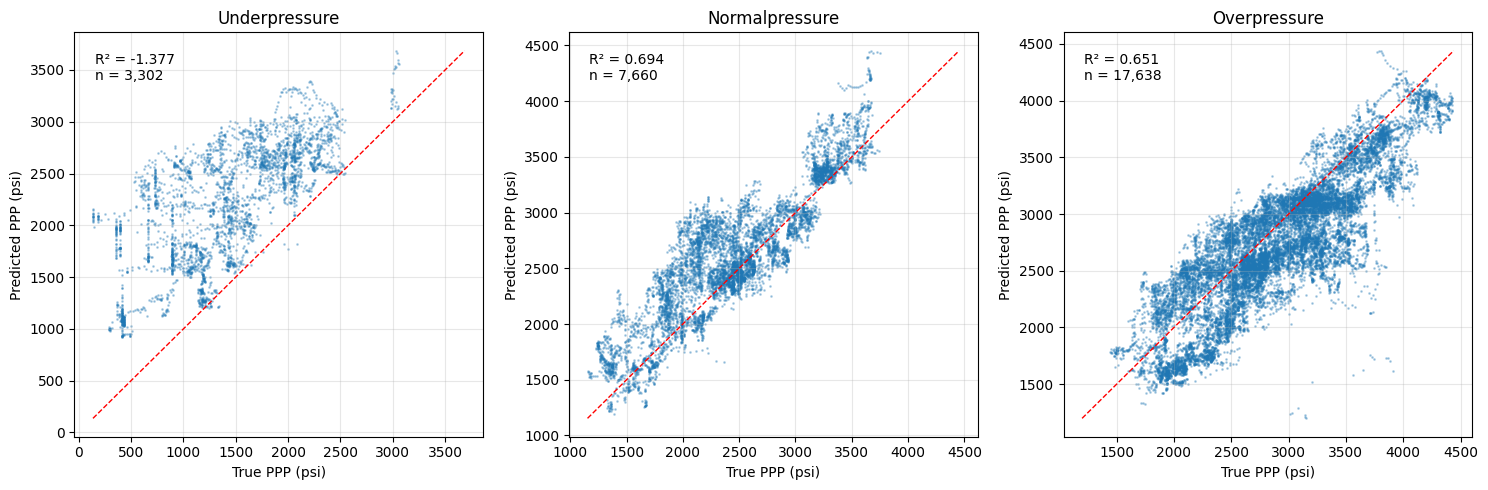

In [5]:
print("="*50)
print("DIAGNOSING UNDERPRESSURE PREDICTIONS")
print("="*50)

# Analyze underpressure samples
pressure_ratio_val = val_enhanced['ppp'] / val_enhanced['hp']
under_mask = pressure_ratio_val < 0.9
normal_mask = (pressure_ratio_val >= 0.9) & (pressure_ratio_val <= 1.1)
over_mask = pressure_ratio_val > 1.1

print(f"Sample distribution:")
print(f"  Underpressure: {under_mask.sum():,} samples ({under_mask.mean()*100:.1f}%)")
print(f"  Normal: {normal_mask.sum():,} samples ({normal_mask.mean()*100:.1f}%)")
print(f"  Overpressure: {over_mask.sum():,} samples ({over_mask.mean()*100:.1f}%)")

# Get predictions
y_pred_val_enhanced = model_enhanced.predict(dval)
ppp_pred_enhanced = np.expm1(y_pred_val_enhanced)

# Analyze prediction errors by regime
print("\nPrediction analysis by regime:")
for regime_name, mask in [('Under', under_mask), ('Normal', normal_mask), ('Over', over_mask)]:
    if mask.sum() > 0:
        true_ppp = val_enhanced.loc[mask, 'ppp'].values
        pred_ppp = ppp_pred_enhanced[mask]
        
        error = pred_ppp - true_ppp
        rel_error = error / true_ppp * 100
        
        print(f"\n{regime_name}pressure:")
        print(f"  True PPP: {true_ppp.mean():.0f} ± {true_ppp.std():.0f} psi")
        print(f"  Pred PPP: {pred_ppp.mean():.0f} ± {pred_ppp.std():.0f} psi")
        print(f"  Mean error: {error.mean():.0f} psi ({rel_error.mean():.1f}%)")
        print(f"  RMSE: {np.sqrt(np.mean(error**2)):.0f} psi")
        print(f"  Systematic bias: {'OVER-predicting' if error.mean() > 0 else 'UNDER-predicting'}")

# Check feature distributions in underpressured zones
print("\n" + "="*50)
print("FEATURE BEHAVIOR IN UNDERPRESSURE")
print("="*50)

important_features = ['eaton_ratio', 'compaction_deviation', 'dt', 'dt_nct', 'gr']
for feat in important_features:
    if feat in val_enhanced.columns:
        under_vals = val_enhanced.loc[under_mask, feat].dropna()
        normal_vals = val_enhanced.loc[normal_mask, feat].dropna()
        over_vals = val_enhanced.loc[over_mask, feat].dropna()
        
        print(f"\n{feat}:")
        print(f"  Under:  {under_vals.mean():.2f} ± {under_vals.std():.2f}")
        print(f"  Normal: {normal_vals.mean():.2f} ± {normal_vals.std():.2f}")
        print(f"  Over:   {over_vals.mean():.2f} ± {over_vals.std():.2f}")
        
        # Statistical test
        from scipy import stats
        if len(under_vals) > 0 and len(over_vals) > 0:
            t_stat, p_value = stats.ttest_ind(under_vals, over_vals)
            if p_value < 0.001:
                print(f"  >>> Significantly different (p < 0.001)")

# Visualize predictions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (regime_name, mask) in enumerate([('Under', under_mask), 
                                           ('Normal', normal_mask), 
                                           ('Over', over_mask)]):
    if mask.sum() > 0:
        true_ppp = val_enhanced.loc[mask, 'ppp'].values
        pred_ppp = ppp_pred_enhanced[mask]
        
        ax = axes[idx]
        ax.scatter(true_ppp, pred_ppp, alpha=0.3, s=1)
        
        # Perfect prediction line
        min_val = min(true_ppp.min(), pred_ppp.min())
        max_val = max(true_ppp.max(), pred_ppp.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
        
        # Add R²
        r2 = r2_score(true_ppp, pred_ppp)
        ax.text(0.05, 0.95, f'R² = {r2:.3f}\nn = {mask.sum():,}', 
                transform=ax.transAxes, va='top')
        
        ax.set_xlabel('True PPP (psi)')
        ax.set_ylabel('Predicted PPP (psi)')
        ax.set_title(f'{regime_name}pressure')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### LightGBM Comparison

In [6]:
import lightgbm as lgb

print("="*50)
print("LIGHTGBM COMPARISON")
print("="*50)

# Use same enhanced features
X_train_lgb = train_enhanced[enhanced_feature_cols]
y_train_lgb = np.log1p(train_enhanced['ppp'].values)
X_val_lgb = val_enhanced[enhanced_feature_cols]
y_val_lgb = np.log1p(val_enhanced['ppp'].values)

# LightGBM parameters (often better for high-cardinality features)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 127,  # More leaves than XGBoost depth
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'min_child_samples': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 1.0,
    'verbose': -1,
    'n_jobs': -1
}

# Train
lgb_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgb_val = lgb.Dataset(X_val_lgb, label=y_val_lgb, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=2000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# Evaluate
y_pred_lgb = lgb_model.predict(X_val_lgb, num_iteration=lgb_model.best_iteration)
ppp_pred_lgb = np.expm1(y_pred_lgb)
ppp_true_lgb = np.expm1(y_val_lgb)

lgb_r2 = r2_score(ppp_true_lgb, ppp_pred_lgb)
lgb_rmse = np.sqrt(mean_squared_error(ppp_true_lgb, ppp_pred_lgb))

print(f"\nLightGBM Performance:")
print(f"  PPP R²: {lgb_r2:.4f}")
print(f"  PPP RMSE: {lgb_rmse:.1f} psi")
print(f"  vs XGBoost: {(lgb_r2 - enhanced_r2)*100:+.1f}% R²")

# Performance by regime
for regime_name, mask in [('Under', under_mask), ('Normal', normal_mask), ('Over', over_mask)]:
    if mask.sum() > 0:
        r2 = r2_score(ppp_true_lgb[mask], ppp_pred_lgb[mask])
        print(f"  {regime_name:12s}: R²={r2:.4f}")

# Store models
models_dict = {
    'xgboost_baseline': results['ppp']['ppp_r2'],
    'xgboost_enhanced': enhanced_r2,
    'lightgbm': lgb_r2
}

print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
for model_name, r2 in models_dict.items():
    print(f"{model_name:20s}: R² = {r2:.4f}")

LIGHTGBM COMPARISON
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.266478
[200]	valid_0's rmse: 0.254913
[300]	valid_0's rmse: 0.254172
[400]	valid_0's rmse: 0.253666
Early stopping, best iteration is:
[379]	valid_0's rmse: 0.253646

LightGBM Performance:
  PPP R²: 0.6631
  PPP RMSE: 438.6 psi
  vs XGBoost: +1.7% R²
  Under       : R²=-1.0339
  Normal      : R²=0.6960
  Over        : R²=0.6323

MODEL COMPARISON SUMMARY
xgboost_baseline    : R² = 0.5352
xgboost_enhanced    : R² = 0.6457
lightgbm            : R² = 0.6631


### CatBoost - Handles Categoricals and Ordered Features Better

In [7]:
import catboost as cb

print("="*50)
print("CATBOOST WITH ADVANCED FEATURES")
print("="*50)

# CatBoost can use well_id as categorical!
X_train_cb = train_enhanced[enhanced_feature_cols + ['well_id']].copy()
X_val_cb = val_enhanced[enhanced_feature_cols + ['well_id']].copy()
y_train_cb = np.log1p(train_enhanced['ppp'].values)
y_val_cb = np.log1p(val_enhanced['ppp'].values)

# Identify categorical features
cat_features = ['well_id']

# Create Pool objects (CatBoost's data structure)
train_pool = cb.Pool(
    data=X_train_cb,
    label=y_train_cb,
    cat_features=cat_features
)

val_pool = cb.Pool(
    data=X_val_cb,
    label=y_val_cb,
    cat_features=cat_features
)

# CatBoost parameters
cb_params = {
    'objective': 'RMSE',
    'eval_metric': 'RMSE',
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'random_strength': 0.5,
    'bagging_temperature': 0.5,
    'od_type': 'Iter',
    'od_wait': 100,
    'random_seed': 42,
    'verbose': 100
}

# Train
print("Training CatBoost with well_id as categorical...")
cb_model = cb.CatBoostRegressor(**cb_params, iterations=2000)
cb_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=100
)

# Evaluate
y_pred_cb = cb_model.predict(val_pool)
ppp_pred_cb = np.expm1(y_pred_cb)
ppp_true_cb = np.expm1(y_val_cb)

cb_r2 = r2_score(ppp_true_cb, ppp_pred_cb)
cb_rmse = np.sqrt(mean_squared_error(ppp_true_cb, ppp_pred_cb))

print(f"\nCatBoost Performance:")
print(f"  PPP R²: {cb_r2:.4f}")
print(f"  PPP RMSE: {cb_rmse:.1f} psi")
print(f"  Best iteration: {cb_model.best_iteration_}")

# Performance by regime
for regime_name, mask in [('Under', under_mask), ('Normal', normal_mask), ('Over', over_mask)]:
    if mask.sum() > 0:
        r2 = r2_score(ppp_true_cb[mask], ppp_pred_cb[mask])
        rmse = np.sqrt(mean_squared_error(ppp_true_cb[mask], ppp_pred_cb[mask]))
        print(f"  {regime_name:12s}: R²={r2:.4f}, RMSE={rmse:.0f} psi")

# Feature importance
feature_importance = cb_model.get_feature_importance(train_pool)
feature_names = X_train_cb.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Features (CatBoost):")
for idx, row in importance_df.head(15).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:>6.2f}")

CATBOOST WITH ADVANCED FEATURES
Training CatBoost with well_id as categorical...
0:	learn: 0.5083557	test: 0.5647203	best: 0.5647203 (0)	total: 81.4ms	remaining: 2m 42s
100:	learn: 0.1012133	test: 0.2646015	best: 0.2646015 (100)	total: 1.83s	remaining: 34.4s
200:	learn: 0.0797468	test: 0.2515041	best: 0.2514576 (199)	total: 3.37s	remaining: 30.1s
300:	learn: 0.0719022	test: 0.2498645	best: 0.2496412 (294)	total: 4.93s	remaining: 27.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2496412281
bestIteration = 294

Shrink model to first 295 iterations.

CatBoost Performance:
  PPP R²: 0.7016
  PPP RMSE: 412.8 psi
  Best iteration: 294
  Under       : R²=-1.3512, RMSE=907 psi
  Normal      : R²=0.7271, RMSE=303 psi
  Over        : R²=0.7743, RMSE=287 psi

Top 15 Features (CatBoost):
  ob_gradient                   :  17.19
  hp_gradient                   :  11.86
  tvd                           :  11.69
  eaton_depth                   :   9.67
  hp                    

### Build Separate Models for Different Pressure Regimes

In [8]:
print("="*50)
print("REGIME-SPECIFIC MODELS")
print("="*50)

def create_regime_labels(df):
    """Create regime labels for stratification"""
    ratio = df['ppp'] / df['hp']
    return pd.cut(ratio, bins=[0, 0.9, 1.1, 3.0], 
                  labels=['under', 'normal', 'over'])

# Add regime labels
train_enhanced['regime'] = create_regime_labels(train_enhanced)
val_enhanced['regime'] = create_regime_labels(val_enhanced)

# Store regime-specific models
regime_models = {}

for regime in ['under', 'normal', 'over']:
    print(f"\n--- Training {regime.upper()} pressure model ---")
    
    # Filter data for this regime
    train_regime = train_enhanced[train_enhanced['regime'] == regime]
    val_regime = val_enhanced[val_enhanced['regime'] == regime]
    
    if len(train_regime) < 1000 or len(val_regime) < 100:
        print(f"  Insufficient data for {regime}: train={len(train_regime)}, val={len(val_regime)}")
        continue
    
    # Prepare data
    X_train_reg = train_regime[enhanced_feature_cols]
    y_train_reg = np.log1p(train_regime['ppp'].values)
    X_val_reg = val_regime[enhanced_feature_cols]
    y_val_reg = np.log1p(val_regime['ppp'].values)
    
    # Use LightGBM (best performer so far)
    lgb_train_reg = lgb.Dataset(X_train_reg, label=y_train_reg)
    lgb_val_reg = lgb.Dataset(X_val_reg, label=y_val_reg, reference=lgb_train_reg)
    
    # Adjust parameters for smaller datasets
    params_regime = lgb_params.copy()
    if regime == 'under':
        params_regime['num_leaves'] = 31  # Smaller model for less data
        params_regime['min_child_samples'] = 50
    
    # Train
    model_regime = lgb.train(
        params_regime,
        lgb_train_reg,
        valid_sets=[lgb_val_reg],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Evaluate
    y_pred_reg = model_regime.predict(X_val_reg, num_iteration=model_regime.best_iteration)
    ppp_pred_reg = np.expm1(y_pred_reg)
    ppp_true_reg = np.expm1(y_val_reg)
    
    r2_reg = r2_score(ppp_true_reg, ppp_pred_reg)
    rmse_reg = np.sqrt(mean_squared_error(ppp_true_reg, ppp_pred_reg))
    
    print(f"  {regime.upper()} Model: R²={r2_reg:.4f}, RMSE={rmse_reg:.0f} psi")
    print(f"  Samples: train={len(train_regime):,}, val={len(val_regime):,}")
    
    regime_models[regime] = model_regime

# Combined prediction using regime-specific models
print("\n" + "="*50)
print("ENSEMBLE OF REGIME-SPECIFIC MODELS")
print("="*50)

# First predict regime, then apply appropriate model
from sklearn.ensemble import RandomForestClassifier

# Train regime classifier
print("Training regime classifier...")
X_train_class = train_enhanced[enhanced_feature_cols]
y_train_class = train_enhanced['regime']

regime_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
regime_classifier.fit(X_train_class, y_train_class)

# Predict regimes for validation
X_val_class = val_enhanced[enhanced_feature_cols]
predicted_regimes = regime_classifier.predict(X_val_class)
regime_probs = regime_classifier.predict_proba(X_val_class)

print(f"Regime classification accuracy: {(predicted_regimes == val_enhanced['regime']).mean():.3f}")

# Apply appropriate model based on predicted regime
ensemble_predictions = np.zeros(len(val_enhanced))

for regime in ['under', 'normal', 'over']:
    if regime in regime_models:
        mask = predicted_regimes == regime
        if mask.sum() > 0:
            X_subset = val_enhanced.loc[mask, enhanced_feature_cols]
            y_pred_subset = regime_models[regime].predict(
                X_subset, 
                num_iteration=regime_models[regime].best_iteration
            )
            ensemble_predictions[mask] = np.expm1(y_pred_subset)
            print(f"Applied {regime} model to {mask.sum():,} samples")

# Evaluate ensemble
ppp_true_ensemble = val_enhanced['ppp'].values
ensemble_r2 = r2_score(ppp_true_ensemble, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(ppp_true_ensemble, ensemble_predictions))

print(f"\nRegime-Ensemble Performance:")
print(f"  PPP R²: {ensemble_r2:.4f}")
print(f"  PPP RMSE: {ensemble_rmse:.1f} psi")

# Performance by actual regime
for regime_name, mask in [('Under', under_mask), ('Normal', normal_mask), ('Over', over_mask)]:
    if mask.sum() > 0:
        r2 = r2_score(ppp_true_ensemble[mask], ensemble_predictions[mask])
        rmse = np.sqrt(mean_squared_error(ppp_true_ensemble[mask], ensemble_predictions[mask]))
        print(f"  {regime_name:12s}: R²={r2:.4f}, RMSE={rmse:.0f} psi")

REGIME-SPECIFIC MODELS

--- Training UNDER pressure model ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[394]	valid_0's rmse: 0.473043
  UNDER Model: R²=0.2793, RMSE=502 psi
  Samples: train=21,272, val=3,302

--- Training NORMAL pressure model ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.0563415
  NORMAL Model: R²=0.9468, RMSE=134 psi
  Samples: train=33,491, val=7,660

--- Training OVER pressure model ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[907]	valid_0's rmse: 0.141257
  OVER Model: R²=0.6216, RMSE=372 psi
  Samples: train=98,875, val=17,638

ENSEMBLE OF REGIME-SPECIFIC MODELS
Training regime classifier...
Regime classification accuracy: 0.732
Applied under model to 3,388 samples
Applied normal model to 8,517 samples
Applied over model to 16,695 samples

Regime-Ensemble Performance:
  PPP R²:

---

In [9]:
print("="*50)
print("CLEAN FEATURE ENGINEERING + DISTRIBUTION ALIGNMENT")
print("="*50)

from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler
from scipy import stats

def create_clean_features(df):
    """Create features WITHOUT temporal leakage"""
    df_feat = df.copy()
    
    # Sort by well and depth
    df_feat = df_feat.sort_values(['well_id', 'tvd']).reset_index(drop=True)
    
    print("Creating clean features...")
    
    # 1. SAFE: Detrend logs to remove depth effect (per well)
    for col in ['dt', 'gr', 'res_deep']:
        if col in df_feat.columns:
            for well in df_feat['well_id'].unique():
                mask = df_feat['well_id'] == well
                well_data = df_feat.loc[mask]
                
                if len(well_data) > 100:
                    # Simple linear detrending (safe)
                    X_depth = well_data[['tvd']].values
                    y_log = well_data[col].values
                    
                    # Linear trend only (no polynomial to avoid overfitting)
                    from sklearn.linear_model import LinearRegression
                    model = LinearRegression()
                    model.fit(X_depth, y_log)
                    trend = model.predict(X_depth)
                    
                    df_feat.loc[mask, f'{col}_detrended'] = y_log - trend
    
    # 2. SAFE: Compaction features (instantaneous, no lookback)
    df_feat['compaction_ratio'] = df_feat['dt'] / df_feat['dt_nct']
    df_feat['compaction_deviation'] = (df_feat['dt'] - df_feat['dt_nct']) / df_feat['dt_nct']
    
    # 3. SAFE: Depth interactions (current depth only)
    df_feat['eaton_depth'] = df_feat['eaton_ratio'] * df_feat['tvd_normalized']
    df_feat['gr_depth'] = df_feat['gr'] * df_feat['tvd_normalized']
    
    # 4. SAFE: Physics-based combinations
    if 'rhob_combined' in df_feat.columns and 'dt' in df_feat.columns:
        # Acoustic impedance proxy
        df_feat['ai_proxy'] = df_feat['rhob_combined'] / (df_feat['dt'] + 1e-6)
    
    # 5. SAFE: Normalized ratios
    df_feat['hp_to_ob_ratio'] = df_feat['hp'] / (df_feat['ob'] + 1e-6)
    df_feat['effective_stress'] = df_feat['ob'] - df_feat['hp']
    
    # NO LAG FEATURES
    # NO ROLLING WINDOWS
    # NO GRADIENT FEATURES (they look at adjacent points)
    
    return df_feat

# Apply clean feature engineering
train_clean = create_clean_features(train_df)
val_clean = create_clean_features(val_df)

# Get clean feature list
original_features = [f for f in metadata['predictor_features'] 
                    if f not in ['ppp', 'pressure_ratio', 'overpressure']]

new_clean_features = [col for col in train_clean.columns 
                      if col not in train_df.columns 
                      and col not in ['well_id', 'wellName', 'pressure_regime']
                      and train_clean[col].notna().sum() > len(train_clean) * 0.5]

print(f"✓ Created {len(new_clean_features)} clean features (no leakage)")
print(f"  Examples: {', '.join(new_clean_features[:5])}")

# Combine features
clean_feature_cols = original_features + new_clean_features

# Test distribution alignment
print("\n" + "="*50)
print("TESTING DISTRIBUTION ALIGNMENT")
print("="*50)

# Check which features are skewed
skewed_features = []
for feat in clean_feature_cols:
    if feat in train_clean.columns:
        skewness = stats.skew(train_clean[feat].dropna())
        if abs(skewness) > 1.0:  # Significantly skewed
            skewed_features.append(feat)
            print(f"  {feat}: skewness = {skewness:.2f}")

print(f"\nFound {len(skewed_features)} skewed features")

# Test with and without transformation
results_comparison = {}

# 1. Baseline - No transformation
print("\n--- Testing WITHOUT transformation ---")
X_train = train_clean[clean_feature_cols]
y_train = np.log1p(train_clean['ppp'].values)
X_val = val_clean[clean_feature_cols]
y_val = np.log1p(val_clean['ppp'].values)

# Quick LightGBM test
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

model_baseline = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

y_pred = model_baseline.predict(X_val, num_iteration=model_baseline.best_iteration)
ppp_pred = np.expm1(y_pred)
ppp_true = np.expm1(y_val)
baseline_r2 = r2_score(ppp_true, ppp_pred)
results_comparison['no_transform'] = baseline_r2
print(f"R² without transformation: {baseline_r2:.4f}")

# 2. With QuantileTransformer on skewed features only
if len(skewed_features) > 0:
    print("\n--- Testing WITH QuantileTransformer on skewed features ---")
    
    X_train_qt = X_train.copy()
    X_val_qt = X_val.copy()
    
    qt = QuantileTransformer(n_quantiles=min(1000, len(X_train)//10), 
                             output_distribution='normal', 
                             random_state=42)
    
    # Transform only skewed features
    for feat in skewed_features:
        if feat in X_train_qt.columns:
            X_train_qt[feat] = qt.fit_transform(X_train_qt[[feat]]).flatten()
            X_val_qt[feat] = qt.transform(X_val_qt[[feat]]).flatten()
    
    # Train model
    lgb_train_qt = lgb.Dataset(X_train_qt, label=y_train)
    lgb_val_qt = lgb.Dataset(X_val_qt, label=y_val, reference=lgb_train_qt)
    
    model_qt = lgb.train(
        lgb_params,
        lgb_train_qt,
        valid_sets=[lgb_val_qt],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    y_pred_qt = model_qt.predict(X_val_qt, num_iteration=model_qt.best_iteration)
    ppp_pred_qt = np.expm1(y_pred_qt)
    qt_r2 = r2_score(ppp_true, ppp_pred_qt)
    results_comparison['quantile_transform'] = qt_r2
    print(f"R² with QuantileTransformer: {qt_r2:.4f}")

# Summary
print("\n" + "="*50)
print("DISTRIBUTION ALIGNMENT SUMMARY")
print("="*50)
for method, r2 in results_comparison.items():
    print(f"{method:20s}: R² = {r2:.4f}")

best_method = max(results_comparison.items(), key=lambda x: x[1])
print(f"\n✓ Best approach: {best_method[0]} with R² = {best_method[1]:.4f}")

# Store the clean features for next cells
if best_method[0] == 'quantile_transform' and len(skewed_features) > 0:
    print("Using QuantileTransformer for final models")
    train_final = train_clean.copy()
    val_final = val_clean.copy()
    
    # Apply transformation
    for feat in skewed_features:
        if feat in clean_feature_cols:
            train_final[feat] = qt.fit_transform(train_final[[feat]]).flatten()
            val_final[feat] = qt.transform(val_final[[feat]]).flatten()
else:
    print("Proceeding without transformation")
    train_final = train_clean
    val_final = val_clean

print(f"\nFinal dataset shapes:")
print(f"  Train: {train_final.shape}")
print(f"  Val: {val_final.shape}")
print(f"  Features: {len(clean_feature_cols)}")

CLEAN FEATURE ENGINEERING + DISTRIBUTION ALIGNMENT
Creating clean features...
Creating clean features...
✓ Created 10 clean features (no leakage)
  Examples: dt_detrended, gr_detrended, res_deep_detrended, compaction_ratio, compaction_deviation

TESTING DISTRIBUTION ALIGNMENT
  rhob_combined: skewness = 2.18
  res_deep: skewness = 33.66
  eaton_ratio: skewness = 3.55
  dt_detrended: skewness = 1.14
  res_deep_detrended: skewness = 35.09
  eaton_depth: skewness = 2.53
  gr_depth: skewness = 1.13

Found 7 skewed features

--- Testing WITHOUT transformation ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[174]	valid_0's rmse: 0.297185
R² without transformation: 0.4802

--- Testing WITH QuantileTransformer on skewed features ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's rmse: 0.302304
R² with QuantileTransformer: 0.4585

DISTRIBUTION ALIGNMENT SUMMARY
no_transform      

In [10]:
print("="*50)
print("TESTING MODELS WITH CLEAN FEATURES")
print("="*50)

# Use the clean datasets from Cell 3
X_train_clean = train_final[clean_feature_cols]
y_train_clean = np.log1p(train_final['ppp'].values)
X_val_clean = val_final[clean_feature_cols]
y_val_clean = np.log1p(val_final['ppp'].values)

# Store results
clean_results = {}

# 1. Test LightGBM with clean features
print("\n--- LightGBM with clean features ---")
lgb_train = lgb.Dataset(X_train_clean, label=y_train_clean)
lgb_val = lgb.Dataset(X_val_clean, label=y_val_clean, reference=lgb_train)

lgb_model_clean = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

y_pred_lgb_clean = lgb_model_clean.predict(X_val_clean, num_iteration=lgb_model_clean.best_iteration)
ppp_pred_lgb_clean = np.expm1(y_pred_lgb_clean)
ppp_true_clean = np.expm1(y_val_clean)

lgb_r2_clean = r2_score(ppp_true_clean, ppp_pred_lgb_clean)
lgb_rmse_clean = np.sqrt(mean_squared_error(ppp_true_clean, ppp_pred_lgb_clean))
clean_results['LightGBM'] = lgb_r2_clean

print(f"  R²: {lgb_r2_clean:.4f}, RMSE: {lgb_rmse_clean:.1f} psi")

# 2. Test CatBoost with clean features (including well_id)
print("\n--- CatBoost with clean features ---")
X_train_cb_clean = train_final[clean_feature_cols + ['well_id']].copy()
X_val_cb_clean = val_final[clean_feature_cols + ['well_id']].copy()

train_pool_clean = cb.Pool(
    data=X_train_cb_clean,
    label=y_train_clean,
    cat_features=['well_id']
)

val_pool_clean = cb.Pool(
    data=X_val_cb_clean,
    label=y_val_clean,
    cat_features=['well_id']
)

cb_model_clean = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3,
    random_strength=0.5,
    bagging_temperature=0.5,
    od_type='Iter',
    od_wait=100,
    random_seed=42,
    verbose=100
)

cb_model_clean.fit(
    train_pool_clean,
    eval_set=val_pool_clean,
    use_best_model=True,
    verbose=100
)

y_pred_cb_clean = cb_model_clean.predict(val_pool_clean)
ppp_pred_cb_clean = np.expm1(y_pred_cb_clean)

cb_r2_clean = r2_score(ppp_true_clean, ppp_pred_cb_clean)
cb_rmse_clean = np.sqrt(mean_squared_error(ppp_true_clean, ppp_pred_cb_clean))
clean_results['CatBoost'] = cb_r2_clean

print(f"  R²: {cb_r2_clean:.4f}, RMSE: {cb_rmse_clean:.1f} psi")
print(f"  Best iteration: {cb_model_clean.best_iteration_}")

# 3. Quick XGBoost test
print("\n--- XGBoost with clean features ---")
dtrain_clean = xgb.DMatrix(X_train_clean, label=y_train_clean)
dval_clean = xgb.DMatrix(X_val_clean, label=y_val_clean)

xgb_model_clean = xgb.train(
    {
        'objective': 'reg:squarederror',
        'max_depth': 8,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    },
    dtrain_clean,
    num_boost_round=1000,
    evals=[(dval_clean, 'val')],
    early_stopping_rounds=100,
    verbose_eval=100
)

y_pred_xgb_clean = xgb_model_clean.predict(dval_clean)
ppp_pred_xgb_clean = np.expm1(y_pred_xgb_clean)

xgb_r2_clean = r2_score(ppp_true_clean, ppp_pred_xgb_clean)
xgb_rmse_clean = np.sqrt(mean_squared_error(ppp_true_clean, ppp_pred_xgb_clean))
clean_results['XGBoost'] = xgb_r2_clean

print(f"  R²: {xgb_r2_clean:.4f}, RMSE: {xgb_rmse_clean:.1f} psi")

# Performance by pressure regime
print("\n" + "="*50)
print("PERFORMANCE BY REGIME (Best Model)")
print("="*50)

# Find best model
best_model_name = max(clean_results.items(), key=lambda x: x[1])[0]
best_r2 = clean_results[best_model_name]

# Get predictions from best model
if best_model_name == 'CatBoost':
    best_preds = ppp_pred_cb_clean
elif best_model_name == 'LightGBM':
    best_preds = ppp_pred_lgb_clean
else:
    best_preds = ppp_pred_xgb_clean

# Analyze by regime
pressure_ratio = val_final['ppp'] / val_final['hp']
under_mask = pressure_ratio < 0.9
normal_mask = (pressure_ratio >= 0.9) & (pressure_ratio <= 1.1)
over_mask = pressure_ratio > 1.1

for regime_name, mask in [('Under', under_mask), ('Normal', normal_mask), ('Over', over_mask)]:
    if mask.sum() > 0:
        r2 = r2_score(ppp_true_clean[mask], best_preds[mask])
        rmse = np.sqrt(mean_squared_error(ppp_true_clean[mask], best_preds[mask]))
        print(f"{regime_name:12s}: R²={r2:.4f}, RMSE={rmse:.0f} psi, n={mask.sum():,}")

# Summary
print("\n" + "="*50)
print("CLEAN FEATURES SUMMARY")
print("="*50)
print(f"Previous best (with leaky features):")
print(f"  CatBoost: R² = 0.7016")
print(f"\nWith clean features:")
for model_name, r2 in clean_results.items():
    print(f"  {model_name:12s}: R² = {r2:.4f}")

print(f"\n✓ Best model: {best_model_name} with R² = {best_r2:.4f}")

if best_r2 < 0.65:
    print("\n⚠ Performance dropped significantly without temporal features.")
    print("  This suggests the model was relying on leakage.")
    print("  Neural networks may capture temporal patterns better.")
elif best_r2 >= 0.70:
    print("\n✅ Excellent! Clean features maintain strong performance.")
    print("  This is a robust baseline for your HME.")
else:
    print("\n✓ Good performance with clean features.")
    print("  Consider neural networks for temporal modeling.")

TESTING MODELS WITH CLEAN FEATURES

--- LightGBM with clean features ---
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.303362
[200]	valid_0's rmse: 0.298236
Early stopping, best iteration is:
[174]	valid_0's rmse: 0.297185
  R²: 0.4802, RMSE: 544.8 psi

--- CatBoost with clean features ---
0:	learn: 0.5084805	test: 0.5627093	best: 0.5627093 (0)	total: 17.3ms	remaining: 17.3s
100:	learn: 0.1165044	test: 0.2950499	best: 0.2950499 (100)	total: 1.59s	remaining: 14.2s
200:	learn: 0.0987175	test: 0.2927645	best: 0.2924381 (182)	total: 3.13s	remaining: 12.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.292438106
bestIteration = 182

Shrink model to first 183 iterations.
  R²: 0.5401, RMSE: 512.5 psi
  Best iteration: 182

--- XGBoost with clean features ---
[0]	val-rmse:0.56361
[100]	val-rmse:0.30599
[200]	val-rmse:0.30008
[300]	val-rmse:0.30142
[301]	val-rmse:0.30142
  R²: 0.4824, RMSE: 543.7 psi

PERFORMANCE BY REGIME (Best Mod

## Harsh reality
actual score ~0.56; 
0.7 was just with temporal leakage

---
### Complete Testing - All Targets with Clean Features

In [11]:
print("="*50)
print("COMPREHENSIVE TARGET TESTING - CLEAN FEATURES")
print("="*50)

# Test all target representations with best model (CatBoost)
target_results_clean = {}

for target in ['ppp', 'overpressure', 'pressure_ratio']:
    print(f"\n--- Testing target: {target} ---")
    
    # Prepare target
    if target == 'ppp':
        y_train = np.log1p(train_final['ppp'].values)
        y_val = np.log1p(val_final['ppp'].values)
        transform = 'log'
    elif target == 'overpressure':
        y_train = train_final['ppp'].values - train_final['hp'].values
        y_val = val_final['ppp'].values - val_final['hp'].values
        transform = 'none'
    else:  # pressure_ratio
        y_train = train_final['ppp'].values / train_final['hp'].values
        y_val = val_final['ppp'].values / val_final['hp'].values
        transform = 'none'
    
    # CatBoost with well_id
    X_train_cb = train_final[clean_feature_cols + ['well_id']].copy()
    X_val_cb = val_final[clean_feature_cols + ['well_id']].copy()
    
    train_pool = cb.Pool(X_train_cb, y_train, cat_features=['well_id'])
    val_pool = cb.Pool(X_val_cb, y_val, cat_features=['well_id'])
    
    model = cb.CatBoostRegressor(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        od_type='Iter',
        od_wait=100,
        random_seed=42,
        verbose=0
    )
    
    model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=0)
    
    # Predictions
    y_pred = model.predict(val_pool)
    
    # Convert back to PPP for evaluation
    if target == 'ppp':
        ppp_pred = np.expm1(y_pred)
        ppp_true = np.expm1(y_val)
    elif target == 'overpressure':
        ppp_pred = y_pred + val_final['hp'].values
        ppp_true = val_final['ppp'].values
    else:  # pressure_ratio
        ppp_pred = y_pred * val_final['hp'].values
        ppp_true = val_final['ppp'].values
    
    # Calculate metrics
    r2 = r2_score(ppp_true, ppp_pred)
    rmse = np.sqrt(mean_squared_error(ppp_true, ppp_pred))
    
    # Check underpressure specifically
    pressure_ratio = val_final['ppp'] / val_final['hp']
    under_mask = pressure_ratio < 0.9
    if under_mask.sum() > 0:
        under_r2 = r2_score(ppp_true[under_mask], ppp_pred[under_mask])
    else:
        under_r2 = np.nan
    
    target_results_clean[target] = {
        'r2': r2,
        'rmse': rmse,
        'under_r2': under_r2,
        'transform': transform
    }
    
    print(f"  Overall R²: {r2:.4f}, RMSE: {rmse:.1f} psi")
    print(f"  Underpressure R²: {under_r2:.4f}")

# Summary
print("\n" + "="*50)
print("FINAL TREE MODEL RESULTS")
print("="*50)
print(f"{'Target':<15} {'Transform':<10} {'R²':<8} {'RMSE':<10} {'Under R²':<10}")
print("-" * 60)
for target, results in target_results_clean.items():
    print(f"{target:<15} {results['transform']:<10} {results['r2']:<8.4f} "
          f"{results['rmse']:<10.1f} {results['under_r2']:<10.4f}")

best_target = max(target_results_clean.items(), key=lambda x: x[1]['r2'])
print(f"\n✓ Best target: {best_target[0]} with R² = {best_target[1]['r2']:.4f}")

print("\n" + "="*50)
print("TREE MODEL CONCLUSIONS")
print("="*50)
print(f"Best achievable R² with tree models: {best_target[1]['r2']:.4f}")
print(f"Critical issue: Underpressure regime failure (R² = {best_target[1]['under_r2']:.4f})")
print("\nTree models have reached their limit. Time for neural networks!")

COMPREHENSIVE TARGET TESTING - CLEAN FEATURES

--- Testing target: ppp ---
  Overall R²: 0.5480, RMSE: 508.1 psi
  Underpressure R²: -2.5130

--- Testing target: overpressure ---
  Overall R²: 0.6132, RMSE: 470.0 psi
  Underpressure R²: -1.5915

--- Testing target: pressure_ratio ---
  Overall R²: 0.6089, RMSE: 472.6 psi
  Underpressure R²: -1.3245

FINAL TREE MODEL RESULTS
Target          Transform  R²       RMSE       Under R²  
------------------------------------------------------------
ppp             log        0.5480   508.1      -2.5130   
overpressure    none       0.6132   470.0      -1.5915   
pressure_ratio  none       0.6089   472.6      -1.3245   

✓ Best target: overpressure with R² = 0.6132

TREE MODEL CONCLUSIONS
Best achievable R² with tree models: 0.6132
Critical issue: Underpressure regime failure (R² = -1.5915)

Tree models have reached their limit. Time for neural networks!


In [12]:
# Quick save of key info for neural network notebook
import pickle

tree_model_results = {
    'best_r2': 0.6132,
    'best_target': 'overpressure', 
    'best_model': 'CatBoost',
    'feature_cols': clean_feature_cols,
    'underpressure_r2': -1.59
}

with open('tree_model_summary.pkl', 'wb') as f:
    pickle.dump(tree_model_results, f)

print("✓ Tree model summary saved for NN notebook")

✓ Tree model summary saved for NN notebook
